#APScheduler and PyMongo

The following is a simple example using APScheduler and PyMongo to pull down the price of bitcoin every minute using the <a href="http://www.coindesk.com/api/" target="_blank">CoinDesk API</a>, storing it the prices in a Mongo database and then importing them into pandas for plotting.

If running these notebooks make sure to have a mongod instance running.

In [1]:
from pymongo import MongoClient

client = MongoClient()
bitcoin = client.test_database.bitcoin

In [8]:
import urllib2
import requests

response = requests.get("http://api.coindesk.com/v1/bpi/currentprice.json")
bitcoin_response = response.json()
print bitcoin_response['bpi']['EUR']['rate_float']

212.2756


First we created a function, get_price(), which APScheduler will call every minute. The function gets JSON from the CoinDesk API page and from this we extract the current price in Euro. We insert this value and the current time into our bitcoin collection

In [9]:
from apscheduler.schedulers.blocking import BlockingScheduler
import datetime

def get_price():
    response = requests.get("http://api.coindesk.com/v1/bpi/currentprice.json")
    bitcoin_response = response.json()
    price = bitcoin_response['bpi']['EUR']['rate_float']
    time = datetime.datetime.now()
    
    bitcoin.insert({"time" : time, "price" : price})    

There are many different types of schedulers, with <a href="http://apscheduler.readthedocs.org/en/latest/modules/schedulers/blocking.html" target="_blank">BlockingScheduler</a> being described as the easiest to use. Using add_job() we add the function that we want called tell it that it will be called a intervals of 1 minute. There are many other ways the function can be called and can be found in the <a href="http://apscheduler.readthedocs.org/en/latest/index.html" target="_blank">documents.</a>

I let this block run for a few minutes and then pressed the stop button to interupt the kernel.

In [10]:
bitcoin.remove({}) #Added to empty out the collection the first time the code is run

scheduler = BlockingScheduler()
scheduler.add_job(get_price, 'interval', minutes=1)

try:
    scheduler.start()
except (KeyboardInterrupt, SystemExit):
    pass

The following can be run while the kernal is still running and adding prices to the collection but will need to be done outside of ipython notebook. I also have spyder installed and was able to run "for price in bitcoin.find(): print price"
Below we convert the collection to a pandas dataframe and then make a plot of the price movement. 

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

bitcoin_df =  pd.DataFrame(list(bitcoin.find()))
bitcoin_df.head()

Populating the interactive namespace from numpy and matplotlib


,_id,price,time
0,55f2f0dd8b92f71c58c7b29f,212.3927,2015-09-11 16:18:53.533000
1,55f2f1198b92f71c58c7b2a0,212.3283,2015-09-11 16:19:53.444000
2,55f2f1568b92f71c58c7b2a1,212.2782,2015-09-11 16:20:54.543000
3,55f2f1938b92f71c58c7b2a2,212.3580,2015-09-11 16:21:55.219000
4,55f2f1cd8b92f71c58c7b2a3,212.3580,2015-09-11 16:22:53.529000


In [15]:
len(bitcoin_df)

16

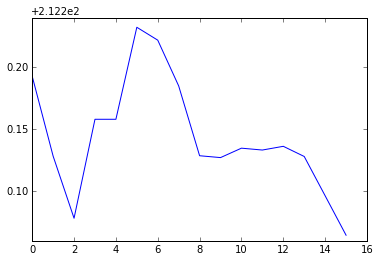

In [16]:
plt.plot(bitcoin_df['price'])